In [1]:
#imports
from __future__ import division, print_function, unicode_literals
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from six.moves import urllib
try:
    from sklearn.impute import SimpleImputer #Scikit-learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.externals import joblib 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
import os
import tarfile
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.pathjoin(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
#ignore warnings    
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
    

/anaconda3/envs/dat158/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Get the Data

Vi henter dataen fra mappen og ser på top 10 radene.

In [2]:
housing = pd.read_csv('dat158-2019/housing_data.csv')
test = pd.read_csv('dat158-2019/housing_test_data.csv')

In [3]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,172200.0,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,359900.0,<1H OCEAN
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,258200.0,<1H OCEAN
4,-122.40,37.76,52.0,1529.0,385.0,1347.0,348.0,2.9312,239100.0,NEAR BAY
5,-118.10,33.90,40.0,1880.0,377.0,1229.0,378.0,4.4167,174600.0,<1H OCEAN
6,-119.45,36.16,27.0,2119.0,373.0,1268.0,345.0,2.8152,106900.0,INLAND
7,-122.31,38.30,45.0,3023.0,659.0,1789.0,657.0,3.6039,126000.0,NEAR BAY
8,-121.45,38.48,28.0,2780.0,510.0,1638.0,533.0,2.9571,103100.0,INLAND
9,-118.96,35.37,41.0,1463.0,339.0,1066.0,318.0,1.7467,52400.0,INLAND


Når vi ser på datasettet kan vi se at hvert distrikt har 10 forskjellige funksjoner som brukes til å beskrive et distrikt.

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.568763,35.630270,28.714571,2636.885841,537.999755,1425.131783,499.837936,3.871083,207262.390080
std,2.003747,2.137134,12.589203,2195.840228,422.944167,1126.453504,383.400473,1.909994,115838.329585
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.562500,120000.000000
50%,-118.490000,34.260000,29.000000,2122.500000,434.000000,1163.000000,409.000000,3.529450,180400.000000
75%,-118.010000,37.710000,37.000000,3137.000000,646.000000,1723.000000,603.000000,4.746450,265100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


Count: dette er antall verdier som er registrert for den gitte kolonnen. 
mean: Gjennomsnittsverdien. 
std: forkortelse for standardavvik. 
min: Den registrerte minimumsverdien for den gitte kolonnen.
25%, 50% og 75%: Den tilsvarende persentilen. For eksempel: 75% er under 37,71 breddegrad, 50% er under 34,26 breddegrad og 25% er belo 33,93 breddegrad. maks: Den registrerte maksimale verdien for den gitte kolonnen.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16344 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7346
INLAND        5214
NEAR OCEAN    2112
NEAR BAY      1835
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.568763,35.630270,28.714571,2636.885841,537.999755,1425.131783,499.837936,3.871083,207262.390080
std,2.003747,2.137134,12.589203,2195.840228,422.944167,1126.453504,383.400473,1.909994,115838.329585
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.562500,120000.000000
50%,-118.490000,34.260000,29.000000,2122.500000,434.000000,1163.000000,409.000000,3.529450,180400.000000
75%,-118.010000,37.710000,37.000000,3137.000000,646.000000,1723.000000,603.000000,4.746450,265100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


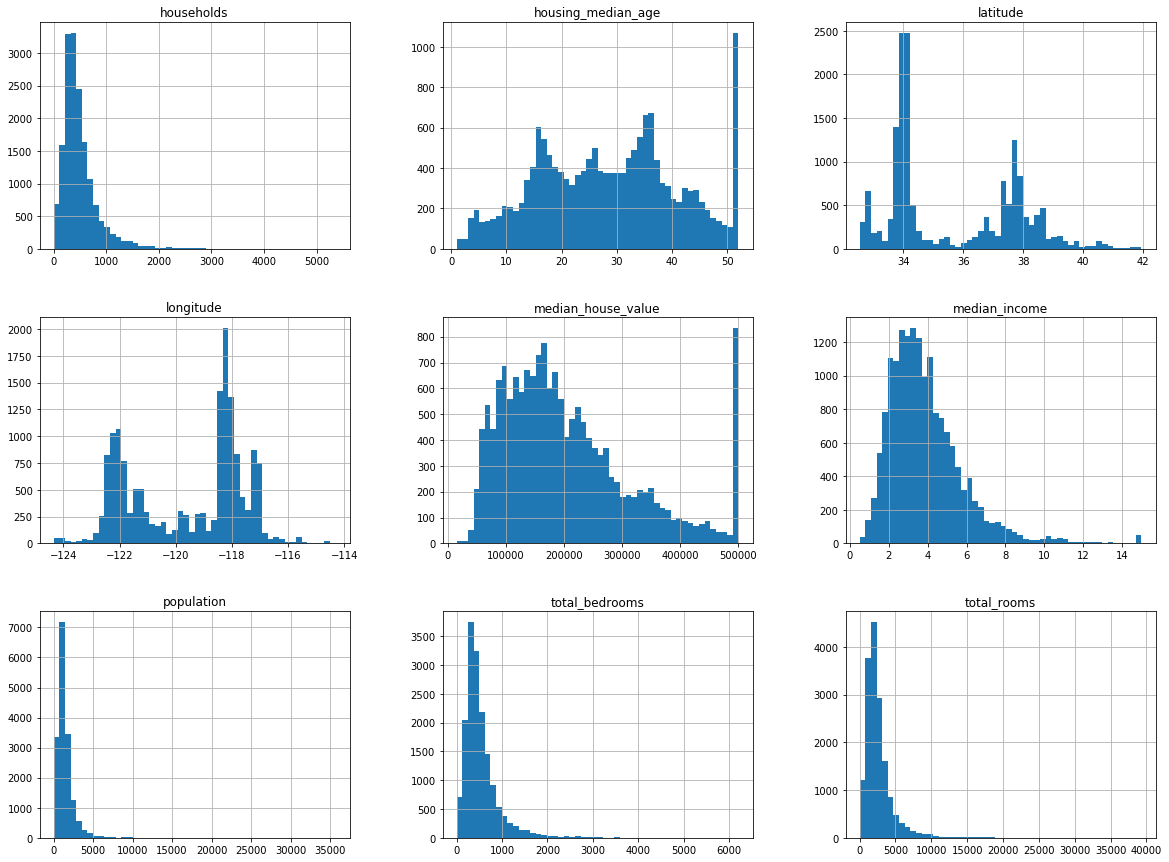

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Test Set


For ethvert ML-problem av denne art er det viktig å sette av et testsett med dataene våre. Testdatasettet er et datasett som brukes til å gi en objektiv evaluering av en endelig modell som passer på treningsdatasettet. Det er mange måter å gjøre dette på. Vi bruker en funksjon fra sklearn som heter "train_test_split". Som vil dele datasettet i to deler; 20% av datasettet blir satt til side som et testsett og de resterende 80% vil være treningssettet. Delingen gjøres tilfeldig.

In [9]:
y = housing["median_house_value"]
X = housing.drop(["median_house_value"], axis = 1)
train_X, train_y, test_X, test_y = train_test_split(X, y, random_state=42)
train_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2611,-121.57,39.78,18.0,2221.0,459.0,952.0,440.0,2.0458,INLAND
7883,-120.27,34.72,14.0,1289.0,277.0,693.0,237.0,3.2569,<1H OCEAN
2818,-122.03,37.98,16.0,1209.0,477.0,627.0,482.0,1.3894,NEAR BAY
219,-117.98,33.77,7.0,2252.0,570.0,1576.0,550.0,3.6333,<1H OCEAN
16139,-118.39,33.87,19.0,3303.0,584.0,1329.0,569.0,7.5210,<1H OCEAN


Foretar stratified prøvetaking basert på inntektskategorien.

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

13210 train + 3302 test


In [12]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1166,-117.36,33.20,19.0,1926.0,557.0,1190.0,483.0,1.3269,166100.0,NEAR OCEAN
5534,-122.02,37.33,25.0,3823.0,584.0,1689.0,571.0,7.3693,373600.0,<1H OCEAN
14016,-122.27,40.53,17.0,2255.0,416.0,1171.0,411.0,2.8750,129800.0,INLAND
9591,-121.46,38.49,15.0,10211.0,1995.0,5656.0,1752.0,2.5750,107900.0,INLAND
12670,-117.18,32.79,30.0,5201.0,1104.0,2961.0,1064.0,3.2661,140400.0,NEAR OCEAN


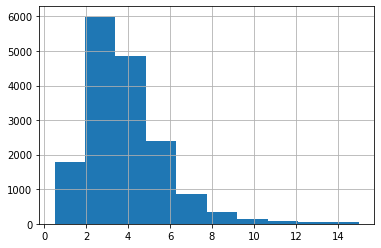

In [13]:
housing["median_income"].hist()

Medianinntektsverdiene visualisert i histogrammet viser oss at de fleste distriktene har en medianinntekt på et sted mellom 20.000 - 50.000 usd. Men som du ser er det noen medianinntekter som er mye mer, og også en liten del som ligger under dette.
For å forhindre partiske estimater av stratum er det viktig å ikke ha for mange lag og hvert stratum skal være stort nok. I våre tilfeller er ikke strammene som er over 6 år store nok, ved å slå sammen stratumene større enn 5 sammen vil dette løse problemet.

In [14]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5): 
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index() # adds an `index` column 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]  #adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [18]:
housing["income_cat"].value_counts()

3.0    5789
2.0    5265
4.0    2911
5.0    1889
1.0     658
Name: income_cat, dtype: int64

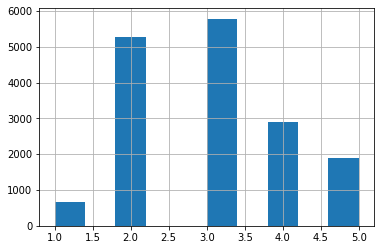

In [19]:
housing["income_cat"].hist()

Ettersom vi nå har laget kategorier som vi kan plassere alle forekomster i datasettet i, er vi klare til å foreta stratified sampling. stratified sampling er illustrert på bildet nedenfor.

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350590
2.0    0.318801
4.0    0.176203
5.0    0.114441
1.0    0.039964
Name: income_cat, dtype: float64

In [22]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

For å få datasettet tilbake til den opprinnelige tilstanden, bruker vi koden nedenfor for å fjerne den tilføyde kolonnen "Income_category".

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [24]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039850,0.039964,0.043294,8.642875,0.285731
2.0,0.318859,0.318801,0.327884,2.830320,-0.018165
3.0,0.350594,0.350590,0.346655,-1.123509,-0.000894
4.0,0.176296,0.176203,0.177717,0.806144,-0.052512
5.0,0.114402,0.114441,0.104450,-8.698430,0.034763


In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

Tidligere delte vi datasettet i et treningssett og et testsett. Nå må vi passe på at vi ikke rører testsettet under trening.

In [26]:
housing = strat_train_set.copy()

# Visualizing Geographical Data

Datasettet inneholder noen geografiske data, breddegrad og lengdegrad i boligdistriktene i California. Det kan være en god ide å plotte dette for å se hvordan distriktene er spredt på kartet.

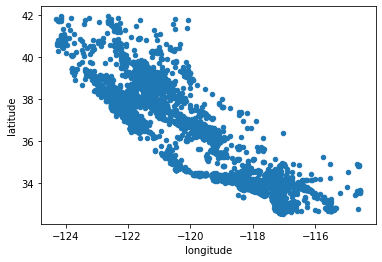

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude")

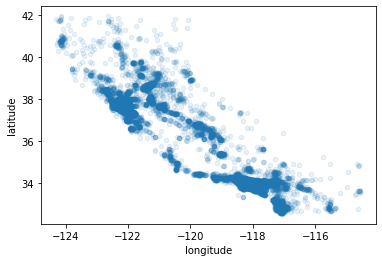

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

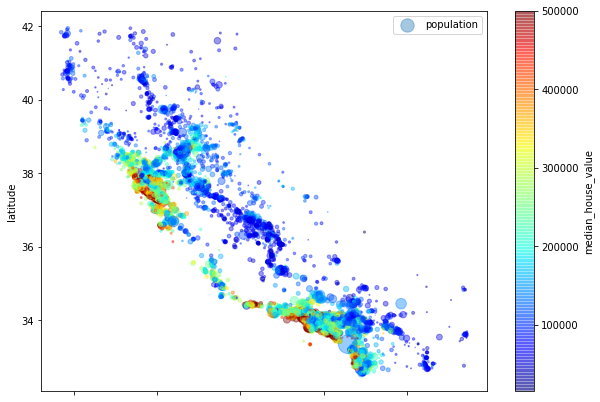

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Blå er lav pris, og rød er høy pris, det er dyrt nært og i San Francisco, Los Angeles og San Diego

# Looking for Correlations


En måte å oppdage korrelasjoner mellom data på er å beregne korrelasjonskoeffisienten.
Korrelasjonskoeffisientformler brukes for å finne hvor sterk sammenheng mellom data er. Formlene returnerer en verdi mellom -1 og 1, der:
1 indikerer et sterkt positivt forhold. -1 indikerer et sterkt negativt forhold. Et resultat av null indikerer ikke noe forhold i det hele tatt. Derfor bruker vi corr()

In [30]:
corr_matrix = housing.corr()

In [31]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685704
total_rooms           0.133077
housing_median_age    0.106092
households            0.063955
total_bedrooms        0.047995
population           -0.026638
longitude            -0.041681
latitude             -0.149024
Name: median_house_value, dtype: float64

Ser vi på korrelasjonsverdiene er det to funksjoner som ser ut til å korrelere lineært med medianhusverdien; medianinntekt og breddegrad. Median_income er fornuftig, når du har en høyere inntekt, det er mer sannsynlig at du har råd til et dyrere hus, derfor den sterke positive korrelasjonsverdien. Vi har også breddegrad med den negative korrelasjonen, dette betyr at når breddegraden øker, har husverdien en tendens til å synke. Dette er også fornuftig å se på spredningsplottet jeg opprettet tidligere, lenger nord syntes boligverdien å gå ned.

En annen måte å lete etter korrelasjoner i datasettet vårt er å bruke Pandas 'scatter_matrix-funksjon, som plotter hvert numerisk attributt mot hvert annet numerisk attributt. For å få plass til alle tomtene vil vi fokusere på attributtene vi mistenker har en sammenheng med median_house_value.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22a3f450>,
      dtype=object)

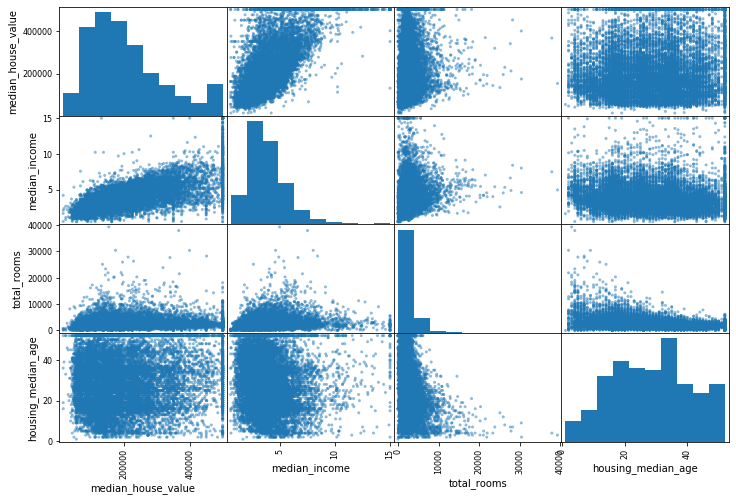

In [32]:
attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

Når man ser på spredningsmatrisen er det litt vanskelig å finne korrelasjoner. Man kan se at rommene i et hus korrelerer med husets alder. Men det er en tomt som tydelig skiller seg ut, som var forventet; medianinntekt og median husverdi.

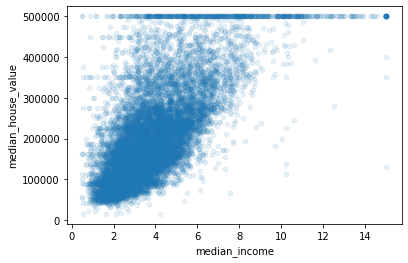

In [33]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

Først av alt kan man se en klar sammenheng mellom medianinntekt og median husverdi. Når medianinntekten øker, øker medianhusverdien. Men det er også noen få andre interessante ting med dette komplottet. Først av alt kan man tydelig se at husverdien har et tak på 500000, derav den tette blå linjen på y = 500 000. I tillegg til dette ser vi et par andre blå linjer, som vi ikke kan forklare. Disse ser ikke ut til å følge det samme mønsteret.

# Experimenting with Attribute Combinations

In [34]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685704
rooms_per_household         0.193628
total_rooms                 0.133077
housing_median_age          0.106092
households                  0.063955
total_bedrooms              0.047995
population_per_household   -0.025622
population                 -0.026638
longitude                  -0.041681
latitude                   -0.149024
bedrooms_per_room          -0.255611
Name: median_house_value, dtype: float64

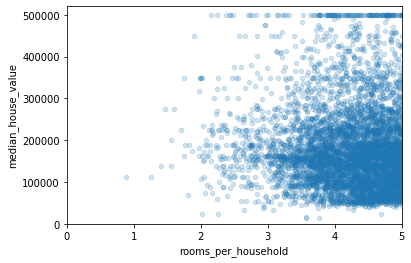

In [36]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [37]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,13209.000000,13209.000000,13209.000000,13209.000000,13083.000000,13209.000000,13209.000000,13209.000000,13209.000000,13209.000000,13083.000000,13209.000000
mean,-119.563785,35.619523,28.704141,2636.232493,537.885347,1428.444318,500.317511,3.873968,207606.217579,5.393556,0.213094,3.100253
std,1.997009,2.131178,12.542755,2189.868049,421.182686,1132.388993,383.258223,1.909787,116027.578521,1.901080,0.058043,12.181447
min,-124.300000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.692308
25%,-121.790000,33.930000,18.000000,1442.000000,294.000000,787.000000,279.000000,2.570100,120300.000000,4.440909,0.175105,2.432727
50%,-118.490000,34.250000,29.000000,2116.000000,433.000000,1163.000000,409.000000,3.528800,180500.000000,5.227778,0.203221,2.825480
75%,-118.010000,37.700000,37.000000,3140.000000,646.000000,1728.000000,603.000000,4.746300,265500.000000,6.057576,0.239916,3.285347
max,-114.560000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,59.875000,1.000000,1243.333333


# 4.Prepare the Data for Machine Learning Algorithms

In [38]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Som forvirret i den første delen når du ser på dataene, er det noen distrikter som mangler en verdi for attributtet "total_bedrooms". Siden de fleste ML-algoritmer ikke fungerer med manglende funksjoner, må vi håndtere dette på noen måte. Det er flere måter å gjøre dette på, en av dem er å sette noen verdi for attributten som mangler. Logisk sett er det fornuftig å sette den til medianverdien.

In [39]:
#housing.dropna(subset=["total_bedrooms"])   #option1
#housing.drop("total_bedrooms", axis=1)      #option1
median = housing["total_bedrooms"].median() #option3
housing["total_bedrooms"].fillna(median, inplace=True)

In [40]:
imputer = SimpleImputer(strategy="median")

In [41]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [42]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [43]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2116.    ,  433.    , 1163.    ,
        409.    ,    3.5288])

In [44]:
housing_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2116.    ,  433.    , 1163.    ,
        409.    ,    3.5288])

In [45]:
X = imputer.transform(housing_num)

In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes 

Tidligere fjernet vi verdien av ocean_proximity fra datasettet vårt for å beregne medianverdiene. Generelt foretrekker ML-algoritmer numeriske verdier, men vi må fortsatt inkludere ocean_proximity-funksjonen i beregningene våre. Derfor må vi transformere attributtet til en numerisk verdi.

In [47]:
encoder = LabelEncoder()

In [48]:
housing_cat = housing["ocean_proximity"]

In [49]:
housing_cat.head(10)

12502    <1H OCEAN
3675     <1H OCEAN
8033        INLAND
10494    <1H OCEAN
1457      NEAR BAY
14086       INLAND
8205     <1H OCEAN
7692     <1H OCEAN
2160     <1H OCEAN
5377        INLAND
Name: ocean_proximity, dtype: object

In [50]:
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [51]:
housing_cat_encoded[:10]

array([0, 0, 1, 0, 2, 1, 0, 0, 0, 1])

In [52]:
housing_categories

Index(['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND'], dtype='object')

ML-algoritmene vil se på de numeriske verdiene (0-4) og tenke at den faktiske verdien vil ha en betydning. Den vil ikke se på verdiene som kategorier, og derfor vil ikke modellen fungere så bra som vi ønsker. For å fikse en mulig løsning er å legge til et binært attributt for hver kategori.

In [53]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot
housing_cat_1hot.toarray()

/anaconda3/envs/dat158/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [54]:
encoder = OneHotEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot
housing_cat_1hot.toarray()

/anaconda3/envs/dat158/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [55]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12502,-118.15,34.12,52.0,1518.0,344.0,725.0,296.0,3.4018,<1H OCEAN
3675,-117.88,34.12,34.0,912.0,165.0,522.0,150.0,4.0417,<1H OCEAN
8033,-121.09,37.33,40.0,524.0,112.0,329.0,96.0,1.7188,INLAND
10494,-118.24,33.99,41.0,1425.0,372.0,1803.0,353.0,1.6731,<1H OCEAN
1457,-122.40,37.72,37.0,971.0,248.0,647.0,208.0,2.1187,NEAR BAY


In [56]:
#from sklearn.base import TransformerMixin #gives fit_transform method for free
#from sklearn import preprocessing 
#class MyLabelBinarizer(TransformerMixin):
 #   def __init__(self, *args, **kwargs):
  #      self.encoder = LabelBinarizer(*args, **kwargs)
   # def fit(self, x, y=0):
    ##   return self
   # def transform(self, x, y=0):
    #    return self.encoder.transform(x)

In [57]:
class MyLabelBinarizer(LabelBinarizer):
    def fit(self, X, y=None):
        return super(MyLabelBinarizer, self).fit(X)
    def transform(self, X, y=None):
        return super(MyLabelBinarizer, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(MyLabelBinarizer, self).fit(X).transform(X)

In [58]:
encoder = MyLabelBinarizer()

In [59]:
housing_cat_1hot = encoder.fit_transform(housing_cat)

In [60]:
#from sklearn.preprocessing import CategoricalEncoder
#cat_encoder = CategoricalEncoder()
#housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
#housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)


In [61]:
#housing_cat_reshaped.toarray()

In [62]:
#housing_cat_1hot.toarray()

## Custom Transformers

ML-algoritmer fungerer ikke bra når attributtene har veldig forskjellige skalaer. Vi kan bruke standardisering for å fikse dette.

In [63]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [64]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
        population_per_household = X[:, population_ix] / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

## Transformation Pipelines

In [65]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [66]:
class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [67]:
#from sklearn_features.transformers import DataFrameSelector

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
             ('selector', DataFrameSelector(num_attribs)),
             ('imputer', SimpleImputer(strategy="median")),
             ('attribs_adder', CombinedAttributesAdder()),
             ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
             ('selector', DataFrameSelector(cat_attribs)),
             ('label_binarizer', MyLabelBinarizer()),
    ])
full_pipeline = FeatureUnion(transformer_list=[
             ("num_pipeline", num_pipeline),
             ("cat_pipeline", cat_pipeline),
    ])

In [68]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.70797764, -0.70363879,  1.85738628, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84318493, -0.70363879,  0.42224052, ...,  0.        ,
         0.        ,  0.        ],
       [-0.76427942,  0.80262716,  0.90062244, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.85820796, -0.8678734 , -1.01290524, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70797764, -0.69894637,  1.69792564, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17991662,  0.79324233, -1.2520962 , ...,  0.        ,
         0.        ,  0.        ]])

In [69]:
housing_prepared.shape

(13209, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

Koden under trener en lineær regresjonsmodell på vårt forhåndsinnlagte treningssett.

In [70]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Testing av modellen på en del av treningssettet

In [71]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [72]:
print("Predictions:\t", lin_reg.predict(some_data_prepared))

Predictions:	 [229160.3070257  212665.75854606  98082.80265673 122004.73357883
 176186.91927408]


In [73]:
print("Labels:\t\t", list(some_labels))

Labels:		 [204500.0, 178000.0, 112500.0, 88200.0, 239300.0]


Når vi ser på resultatene ser vi at modellen ikke akkurat er tilfredsstillende. Da vi begynte med å si at jeg vil bruke Root Mean Squared Error for å måle hvor bra modellen vår yter. Ved å bruke Scikit-leares RMSE-funksjon vil vi nå måle resultatene til modellen på hele treningssettet.

In [74]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69189.070349375

In [75]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49918.922121458

### Decision Tree Regressor

In [76]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Nå som modellen er trent, kan vi gjøre som vi gjorde med Linear Regression-modellen og kjenne modellen på treningssettet.

In [77]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

RMSE returnerte 0,0, så ingen feil i det hele tatt. Det er klart at dette ikke kan være en perfekt modell, det vi ser her er overmasse. En måte å sjekke dette på er å dele opplæringssettet i et treningssett og et valideringssett. Dette fordi vi ikke har lov til å røre testsettet før vi er 100% sikre på at vi er sikre på modellen vår.

## Fine-tune your model: Better Evaluation Using Cross-Validation 

For validering av vår modell bruker vi Scikit-Learns cross-validation-function. Den deler opplæringssettet tilfeldig i 10 distinkte undergrupper kalt bretter, så trener og evaluerer Decision Tree-modellen 10 ganger, og velger en annen brett for evaluering hver gang og trener på de andre 9 foldene.

In [78]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [79]:
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

In [80]:
display_scores(tree_rmse_scores)

Scores: [69204.4962563  73752.74186343 73578.07019426 68289.16954467
 72367.9265809  69967.7305974  75396.49785683 76961.35894218
 71961.91089234 72147.58200369]
Mean: 72362.74847320006
Standard deviation: 2574.32805301069


Når vi ser på resultatene fra kryssvalideringen ser vi nå at beslutningstreet ikke er en perfekt modell. Det scorer faktisk litt dårligere enn Linear regresjonsmodellen.

In [81]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67425.31111647 70545.68245901 65275.34487036 72985.99852065
 66010.80255207 70540.06026376 73335.57983319 70614.41958818
 71803.70040712 67678.50408007]
Mean: 69621.54036908635
Standard deviation: 2703.417700170707


In [82]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [83]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22418.347780027736

In [84]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52887.28266434 54333.17566097 53239.06417465 51439.79555329
 50894.42272248 56996.92261796 57333.50555104 53464.10346659
 53565.56661941 52285.27332189]
Mean: 53643.9112352613
Standard deviation: 2009.2148627384013


Kryssvalideringen av vår Random forrest model ser mye bedre ut enn våre to tidligere modeller.

In [85]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69621.540369
std       2849.652466
min      65275.344870
25%      67488.609357
50%      70542.871361
75%      71506.380202
max      73335.579833
dtype: float64

In [86]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

112722.63824042653

In [87]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([229160.3070257 , 212665.75854606,  98082.80265673, 122004.73357883,
       176186.91927408])

In [88]:
my_model = full_pipeline_with_predictor

In [89]:
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

### Grid Search

In [90]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
    
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


Treningen er nå ferdig, og vi ser på den beste kombinasjonen av params med GridSearch-funksjonen som er generert for oss.

In [91]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [92]:
#rf = RandomForestClassifier(max_features=8, n_estimators = 30)
#rf.fit(housing_prepared, housing_labels)

In [93]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [94]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
    print(np.sqrt(-mean_score), params)

64749.53256471786 {'max_features': 2, 'n_estimators': 3}
56039.92573840984 {'max_features': 2, 'n_estimators': 10}
53199.70862267483 {'max_features': 2, 'n_estimators': 30}
61258.49927594362 {'max_features': 4, 'n_estimators': 3}
53871.85512180222 {'max_features': 4, 'n_estimators': 10}
51499.71356326967 {'max_features': 4, 'n_estimators': 30}
59744.22333635578 {'max_features': 6, 'n_estimators': 3}
53735.37687785806 {'max_features': 6, 'n_estimators': 10}
51425.09549342174 {'max_features': 6, 'n_estimators': 30}
60638.156964736634 {'max_features': 8, 'n_estimators': 3}
52989.27838572595 {'max_features': 8, 'n_estimators': 10}
51242.272995010164 {'max_features': 8, 'n_estimators': 30}
63966.59568523821 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55050.25683318543 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60861.343495477726 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53320.20533921132 {'bootstrap': False, 'max_features': 3, 'n_estimators':

## Analyze the Best Models and Theirs Errors

In [95]:
feature_importances = grid_search.best_estimator_.feature_importances_ 
feature_importances

array([0.06616478, 0.05929257, 0.04164312, 0.01697295, 0.01545343,
       0.01647634, 0.01380246, 0.34909616, 0.03881369, 0.11023624,
       0.08331114, 0.00436494, 0.17864261, 0.00035986, 0.0019862 ,
       0.00338352])

In [96]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"] 
cat_one_hot_attribs = list(encoder.classes_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34909616088998763, 'median_income'),
 (0.17864260805205898, '1'),
 (0.11023624339461732, 'pop_per_hhold'),
 (0.08331113737260411, 'bedrooms_per_room'),
 (0.06616477956031641, 'longitude'),
 (0.05929256968219233, 'latitude'),
 (0.04164312210349819, 'housing_median_age'),
 (0.03881368550820377, 'rooms_per_hhold'),
 (0.016972945375874137, 'total_rooms'),
 (0.016476338799495074, 'population'),
 (0.015453431621060804, 'total_bedrooms'),
 (0.013802455498138723, 'households'),
 (0.004364944945687676, '<'),
 (0.00338351526902697, 'O'),
 (0.00198619852452899, ' '),
 (0.0003598634027088673, 'H')]

## Evaluate Your System on the Set

In [97]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
    
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 48942.54039062595

In [98]:
final_rmse

49939.46552645927

In [99]:
confidence = 0.95

In [100]:
squared_errors = (final_predictions - y_test) **2

In [101]:
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                                        loc=squared_errors.mean(),
                                        scale=stats.sem(squared_errors)))

array([47285.53740049, 52459.30219593])

Fra dette har vi gått gjennom trinnene for å utforske dataene, transformere dem for å passe bedre inn i ML-algoritmene, plukke ut en modell og finjustere dem. Gjennom en relativt liten mengde LOC (men noen kraftige verktøy) har vi vært i stand til å lage et funksjonelt system for å forutsi boligprisene i distriktet, som er bedre enn å gjøre det manuelt. Nøyaktigheten til modellen er ganske bra, men likevel ikke bedre enn den manuelle arbeidskraften. Manuell feilrate = 15%. Men tiden det tar å gjøre spådommene er mindre.

# 8. Launch, Monitor, and Maintain Your System

In [108]:
median_house_value = [0 for i in test['Id']]

In [109]:
test_prepared =full_pipeline.transform(test)

In [110]:
predictions = final_model.predict(test_prepared)

In [111]:
submission = pd.DataFrame({'Id': test['Id'], 'median_house_value': predictions})

In [112]:
submission.to_csv('submission7.csv', index=False)

In [113]:
submission.head()

,Id,median_house_value
0,0,231286.666667
1,1,244993.333333
2,2,74583.333333
3,3,191490.033333
4,4,52026.666667
